# How do we maximise the likelihood?

Now that there is a metric we will use to assess the quality of agreement between our model and our data, we can consider **how** we obtain the maximum likelihood for a given system.
In this section we will look at a couple of common method for likelihood maximisation that are used in neutron reflectometry analysis. 
These methods take on two *flavours*, that we will investigate in turn. 

## Gradient methods

The first method for likelihood maximisation that one will encounter in reflectometry analysis are the **gradient** methods. 
These are optimisation algorithms which aim to maximise the likelihood by starting from initial guess position and finding the local gradient. 
Once this is determined, the gradient method looks to move the current guess uphill to eventually reach some nearby maximum value.
We can see a simple example of this below, where we find the maximum likelihood by a gradient method for a two-dimensional normal distribution. 
````{margin}
```{note} 
Be aware, that many of these algorithms are implemented for **root-finding**, and therefore aim to minimise some function. Therefore, to maximise we simply minimize the negative of the function. 
```
````

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

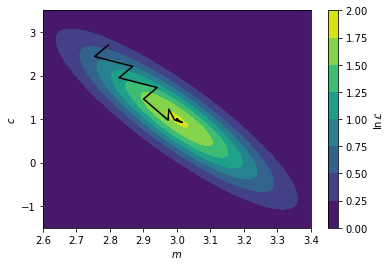

Maximum: [2.99999727 0.99998503]


In [2]:
mv = multivariate_normal([3, 1], [[0.0330252 , -0.16748113], [-0.16748113,  1.09209783]])
gradient_v = []
def gradient_callback(current_theta: np.ndarray) -> None:
    gradient_v.append(current_theta)

def nll(theta: np.ndarray) -> float:
    return -mv.logpdf(theta)

res = minimize(nll, [2.6, 3], callback=gradient_callback, method='Nelder-Mead')
gradient_v = np.array(gradient_v)
x = np.linspace(2.6, 3.4, 1000)
y = np.linspace(-1.5, 3.5, 1000)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, mv.pdf(np.array([X, Y]).T).T)
plt.plot(gradient_v[:, 0], gradient_v[:, 1], 'k-')
plt.xlabel('$m$')
plt.ylabel('$c$')
plt.colorbar(label='$\ln\mathcal{L}$')
plt.show()
print('Maximum:', res.x)

We can see above that the black line, indicating the path of the solution towards the maximum, moves in a rational path up towards the maximum, following the regions of increasing gradient. 
Eventually after a number of steps, the maximum is found.

Gradient methods are effective for discovery of local maxima, however for more complex model-dependent analysis, this can be a problem. 
If the maxima that is found by the gradient method is not the global maxima, then it is not possible for these algorithms to easily go back "downhill". 
This means that the **starting position** of the algorithm is very important. 

Consider the two routes shown below on the multi-modal (more than one maxima) likelihood function. 
The blue line starts near to the local minimum at $(3, 0)$ and therefore the gradient approach is used, it is this minima that is found. 
However, when the algorithm is started from $(10, 5)$ (orange line), the true global minimum at $(8, 2)$ is found instead. 
It is clear that for the **non-unique** analyses of neutron reflectometry, we desire a **global optimisation** approach. 

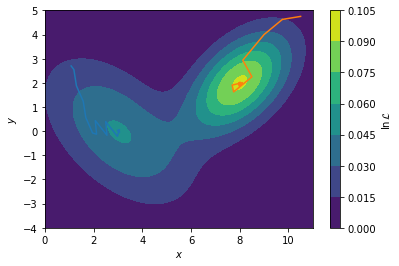

Blue Maximum: [ 3.04493869 -0.02614057]
Orange Maximum: [7.9957561  1.99615666]


In [3]:
mv1 = multivariate_normal([3, 0], [[4, 2], [-2, 4]])
mv2 = multivariate_normal([8, 2], [[2, 1], [1, 2]])

def nll(theta: np.ndarray) -> float:
    return -(mv1.pdf(theta) + mv2.pdf(theta))

x = np.linspace(0, 11, 1000)
y = np.linspace(-4, 5, 1000)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, mv1.pdf(np.array([X, Y]).T).T + mv2.pdf(np.array([X, Y]).T).T)
gradient_v = []
res1 = minimize(nll, [1, 3], callback=gradient_callback, method='Nelder-Mead')
gradient_v = np.array(gradient_v)
plt.plot(gradient_v[:, 0], gradient_v[:, 1], '-')
gradient_v = []
res2 = minimize(nll, [10, 5], callback=gradient_callback, method='Nelder-Mead')
gradient_v = np.array(gradient_v)
plt.plot(gradient_v[:, 0], gradient_v[:, 1], '-')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(label='$\ln\mathcal{L}$')
plt.show()
print('Blue Maximum:', res1.x)
print('Orange Maximum:', res2.x)

## Stochastic methods

The most common form of gloabl optimisation methods are the stochastic methods, where stochastic means **random**.
There are a variety of these methods, such as [particle swarm](https://en.wikipedia.org/wiki/Particle_swarm_optimization), which moves in the semi-random fashion analogus to a swarm of insects, or [evolutionary algorithms](https://en.wikipedia.org/wiki/Evolutionary_algorithm), which are inspired by biological evolution in order to find the optimum. 
The most commonly applied in neutron reflectometry model optimisation is the differential evolution method {cite}`storn_differential_1997,wormington_characterization_1999,bjork_fitting_2011`. 

````{margin}
```{note}
The code used to implement a differential evolution algorithm can be found in the [`helper.py`](https://github.com/arm61/isis_school/blob/main/fitting_processes_and_problems/helper.py) module.
```
````
In the figure below, we show the application of a differential evolution algorithm with a population of $8$ (however, the optimisation route of the $4$ best members are shown). 
It is clear that the methodology results in a more complete assessment of the complex optimisation space. 
Typically once a solution is found using the differential evolution is found, this is further optimised with a gradient descent method to find the maximum global likelihood. 
This is necessary as, as we can see from the oberall maximum, the differential evolution will not find the absolute maximum alone. 

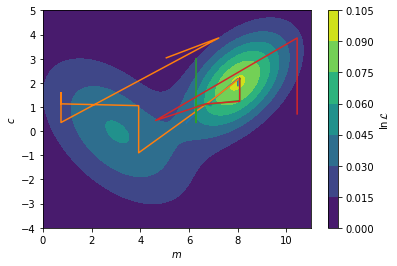

Overall Maximum: [8.07873161 1.88750132]


In [5]:
from helper import differential_evolution

x = np.linspace(0, 11, 1000)
y = np.linspace(-4, 5, 1000)
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, mv1.pdf(np.array([X, Y]).T).T + mv2.pdf(np.array([X, Y]).T).T)
res = differential_evolution(nll, ((0, 11), (-4, 5)))
top4 = np.argsort(nll(res[-1].T))[:4]
plt.plot(res[:, 0, top4], res[:, 1, top4], '-')
plt.xlabel('$m$')
plt.ylabel('$c$')
plt.colorbar(label='$\ln\mathcal{L}$')
plt.show()
print('Overall Maximum:', res[-1].T[np.argmax(nll(res[-1].T))])

Once some likelihood maximum is found, it is valuable to probe the shape of that maximum, to draw conclusions about robustivity of the result, but that is beyond the scope for this course.